In [1]:
import emcee
import numpy as np 
import corner as DFM
# --- emanu---
from emanu import compressor as Comp
from emanu import forecast as Forecast

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
theta_true = np.array([0.5, 0.5])
cov_true = np.identity(20)
def model(theta): 
    return theta[0] * np.arange(20) + theta[1]
X_true = model(theta_true)

In [4]:
X_data = np.random.multivariate_normal(model(theta_true), cov_true, size=10000)
cov_data = np.cov(X_data.T)

cinv_data = np.linalg.inv(cov_data)

nmock, ndata = X_data.shape
cinv_data *= float(nmock - ndata - 2)/float(nmock - 1) 

(0.0, 19.0)

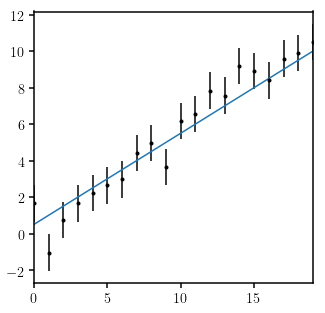

In [5]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.errorbar(range(len(X_true)), X_data[0], np.sqrt(np.diag(cov_true)), fmt='.k')
sub.plot(model(theta_true))
sub.set_xlim(0., 19.)

In [6]:
theta_0m = np.array([theta_true[0]-0.1, theta_true[1]])
theta_0p = np.array([theta_true[0]+0.1, theta_true[1]])
theta_1m = np.array([theta_true[0], theta_true[1]-0.1])
theta_1p = np.array([theta_true[0], theta_true[1]+0.1])
dXd0 = (model(theta_0p) - model(theta_0m))/0.2
dXd1 = (model(theta_1p) - model(theta_1m))/0.2
dXdtheta = np.array([dXd0, dXd1])

In [7]:
cmpsr = Comp.Compressor(method='KL')      
cmpsr.fit(X_data, dXdtheta, hartlap=True)

In [8]:
cX_true = cmpsr.transform(np.atleast_2d(model(theta_true)))

cX_data = cmpsr.transform(X_data)

ccov_data = np.cov(cX_data.T)

ccinv_data = np.linalg.inv(ccov_data) * float(cX_data.shape[0] - cX_data.shape[1] - 2)/float(cX_data.shape[0] - 1) 

(-0.5, 1.5)

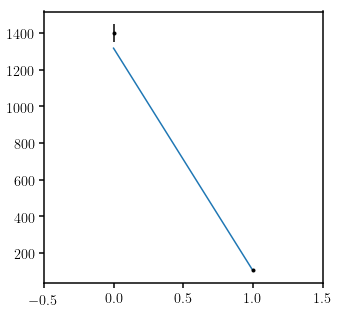

In [9]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.errorbar(range(cX_data.shape[1]), cX_data[0], np.sqrt(np.diag(ccov_data)), fmt='.k')
sub.plot(cX_true.flatten(), c='C0')
sub.set_xlim(-0.5, cX_data.shape[1]-0.5)

running burn-in chain
running main chain


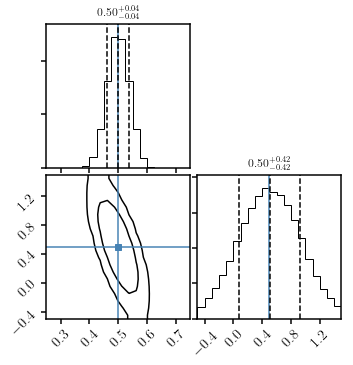

In [10]:
# initialize walkers randomly drawn from prior 
ndim = len(theta_true)

prior_range = np.array([[0.25, 0.75], [-0.5, 1.5]])

def lnprior(tt): 
    ''' log uniform prior. totally uninformative
    '''
    t0, t1 = tt 
    if (prior_range[0][0] <= t0 <= prior_range[0][1]) and (prior_range[1][0] <= t1 <= prior_range[1][1]):
        return 0.0 
    return -np.inf 

def lnlike(tt): 
    ''' log likelihood of the full data
    '''
    delta = (model(tt) - X_true) 
    return -0.5*np.dot(delta, np.dot(cinv_data, delta.T))

def lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + lnlike(tt)

nwalkers=100
burn_in_chain=200
main_chain=1000 

pos = [np.random.uniform(prior_range[:,0], prior_range[:,1]) for i in range(nwalkers)]

# run mcmc 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print('running burn-in chain') 
pos, prob, state = sampler.run_mcmc(pos, burn_in_chain)
sampler.reset()
print('running main chain') 
sampler.run_mcmc(pos, main_chain)

# save chain 
post = sampler.flatchain.copy() 

fig = DFM.corner(post, color='k', quantiles=[0.16, 0.5, 0.84], levels=[0.68, 0.95], 
                 bins=20, range=prior_range, truths=theta_true,
                 smooth=True, show_titles=True, 
                 plot_datapoints=False, plot_density=False, label_kwargs={'fontsize': 20}) 

In [11]:
#true 1-sigma values
q00, q01, q02 = np.quantile(post[:,0], [0.16, 0.5, 0.84])
q10, q11, q12 = np.quantile(post[:,1], [0.16, 0.5, 0.84])
print q01-q00, q11-q10

0.03784750412426918 0.42203148875271806


In [12]:
Fij = Forecast.Fij(dXdtheta, cinv_data) # fisher 
Finv = np.linalg.inv(Fij)

In [13]:
# Fisher "true" 1-sigma values
print np.sqrt(np.diag(Finv))

[0.03893893 0.43620011]


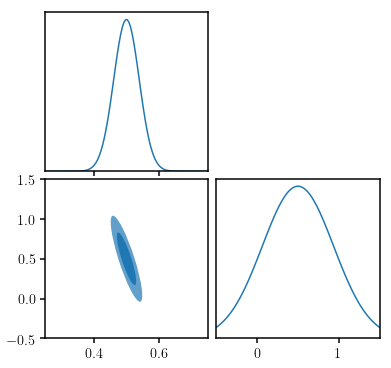

In [14]:
fig = Forecast.plotFisher([Finv], theta_true, ranges=prior_range)

In [15]:
dcXdts = cmpsr.transform(dXdtheta)

cFij = Forecast.Fij(dcXdts, ccinv_data) # fisher 

cFinv = np.linalg.inv(cFij)

In [16]:
print np.sqrt(np.diag(cFinv))

[0.03890386 0.4358072 ]


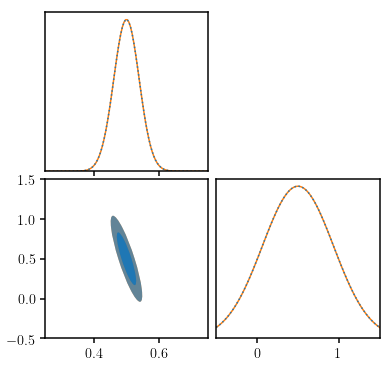

In [17]:
fig = Forecast.plotFisher([cFinv, Finv], theta_true, ranges=prior_range, colors=['C1', 'C0'], linestyles=['-', ':'])

In [44]:
def Finv_noisy_cov(nmocks): 
    _cmpsr_noisy = Comp.Compressor(method='KL')      
    _cmpsr_noisy.fit(X_data[:nmocks], dXdtheta, hartlap=False)
    
    _cX_noisy_data = _cmpsr_noisy.transform(X_data[:nmocks])

    _ccov_noisy_data = np.cov(_cX_noisy_data.T)
    _ccinv_noisy_data = np.linalg.inv(_ccov_noisy_data)
    
    #f_hartlap = float(_cX_noisy_data.shape[0] - _cX_noisy_data.shape[1] - 2)/float(_cX_noisy_data.shape[0] - 1) 
    #_ccinv_noisy_data *= f_hartlap

    _dcXdts_noisy = _cmpsr_noisy.transform(dXdtheta)

    _cFij_noisy = Forecast.Fij(_dcXdts_noisy, _ccinv_noisy_data) # fisher 
    f_tdist = float(nmocks**2)/float((nmock+20+1)*(nmock+20-1))
    print np.diag(np.linalg.inv(_cFij_noisy * f_tdist)), np.diag(np.linalg.inv(_cFij_noisy))
    _cFinv_noisy = np.linalg.inv(_cFij_noisy * f_tdist)
    return _dcXdts_noisy, _cFinv_noisy, _cmpsr_noisy.cM

[0.00151911 0.19063117] [0.00151306 0.18987093]
[0.00150934 0.18772692] [0.00149733 0.18623407]
[0.00164452 0.20936553] [0.00158067 0.2012358 ]
[0.00171952 0.21600104] [0.0015898  0.19970584]
[0.00225827 0.2721307 ] [0.00156836 0.18899277]
[0.00263322 0.29695848] [0.00134375 0.15154035]


(0.0, 19)

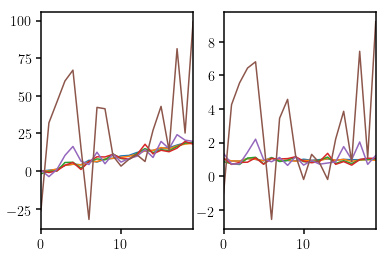

In [45]:
fig = plt.figure()
sub0 = fig.add_subplot(121)
sub1 = fig.add_subplot(122)
for nmock in [10000, 5000, 1000, 500, 100, 50]: 
    _, cFinv_noisy, _cMs = Finv_noisy_cov(nmock)
    sub0.plot(_cMs[0])
    sub1.plot(_cMs[1])
sub0.set_xlim(0., 19)
sub1.set_xlim(0., 19)

In [46]:
Finvs = [] 
for nmock in [1000, 500, 100, 50, 30]: 
    _, cFinv_noisy, _cMs = Finv_noisy_cov(nmock)
    print np.sqrt(np.diag(cFinv_noisy))
    Finvs.append(cFinv_noisy)
Finvs.append(Finv)

[0.00164452 0.20936553] [0.00158067 0.2012358 ]
[0.04055272 0.45756478]
[0.00171952 0.21600104] [0.0015898  0.19970584]
[0.0414671  0.46475912]
[0.00225827 0.2721307 ] [0.00156836 0.18899277]
[0.04752131 0.52166148]
[0.00263322 0.29695848] [0.00134375 0.15154035]
[0.05131491 0.54493896]
[0.00260048 0.25209514] [0.00093655 0.09079057]
[0.05099495 0.50209077]


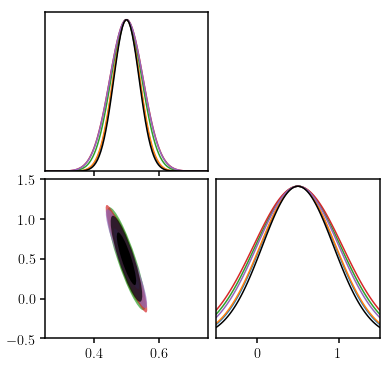

In [47]:
fig = Forecast.plotFisher(Finvs, theta_true, colors=['C0', 'C1', 'C2', 'C3', 'C4', 'k'], ranges=prior_range)

In [23]:
def Finv_noisy_cov_deriv(nmocks): 
    X_data_0m = np.random.multivariate_normal(model([theta_true[0]-0.1, theta_true[1]]), cov_true, size=nmocks)
    X_data_0p = np.random.multivariate_normal(model([theta_true[0]+0.1, theta_true[1]]), cov_true, size=nmocks)

    X_data_1m = np.random.multivariate_normal(model([theta_true[0], theta_true[1]-0.1]), cov_true, size=nmocks)
    X_data_1p = np.random.multivariate_normal(model([theta_true[0], theta_true[1]+0.1]), cov_true, size=nmocks)

    dXd0_noisy = (np.average(X_data_0p, axis=0) - np.average(X_data_0m, axis=0))/0.2
    dXd1_noisy = (np.average(X_data_1p, axis=0) - np.average(X_data_1m, axis=0))/0.2
    dXdtheta_noisy = np.array([dXd0_noisy, dXd1_noisy])
    
    _cmpsr_noisy = Comp.Compressor(method='KL')      
    _cmpsr_noisy.fit(X_data[:nmocks], dXdtheta_noisy)
    
    _cX_noisy_data = _cmpsr_noisy.transform(X_data[:nmocks])

    _ccov_noisy_data = np.cov(_cX_noisy_data.T)

    f_hartlap = float(_cX_noisy_data.shape[0] - _cX_noisy_data.shape[1] - 2)/float(_cX_noisy_data.shape[0] - 1) 
    _ccinv_noisy_data = np.linalg.inv(_ccov_noisy_data) * f_hartlap

    _dcXdts_noisy = _cmpsr_noisy.transform(dXdtheta)

    _cFij_noisy = Forecast.Fij(_dcXdts_noisy, _ccinv_noisy_data) # fisher 

    _cFinv_noisy = np.linalg.inv(_cFij_noisy)
    return dXdtheta_noisy, _cFinv_noisy

In [24]:
dXdtheta_noisy, cFinv_noisy = Finv_noisy_cov_deriv(100)
dXdtheta_noisier, cFinv_noisier = Finv_noisy_cov_deriv(30)

[0.03940322 0.44246702]
[0.04436958 0.51792585]
[0.0426514  0.48893318]
[0.05214498 0.63856628]
[0.0676355  0.81341665]
[0.10955094 1.22408633]


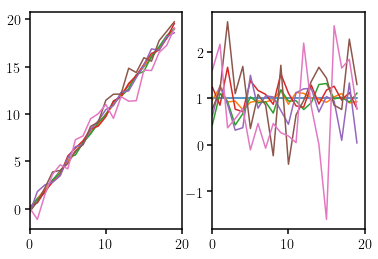

In [25]:
fig = plt.figure()
sub0 = fig.add_subplot(121)
sub0.plot(dXdtheta[0])
sub0.set_xlim(0, X_data.shape[1])
sub1 = fig.add_subplot(122)
sub1.plot(dXdtheta[1])
sub1.set_xlim(0, X_data.shape[1])

for nmock in [5000, 1000, 500, 200, 100, 50]: 
    _dXdtheta_noisy, _cFinv_noisy = Finv_noisy_cov_deriv(nmock)
    print(np.sqrt(np.diag(_cFinv_noisy)))
    sub0.plot(_dXdtheta_noisy[0])
    sub1.plot(_dXdtheta_noisy[1])

In [26]:
Finvs = [] 
for nmock in [1000, 500, 100, 50]: 
    _, cFinv_noisy = Finv_noisy_cov_deriv(nmock)
    print np.sqrt(np.diag(cFinv_noisy))
    Finvs.append(cFinv_noisy)
Finvs.append(cFinv)
Finvs.append(Finv)

[0.04264071 0.49235234]
[0.04448368 0.51574234]
[0.06883639 0.81916496]
[0.07109978 0.7938495 ]


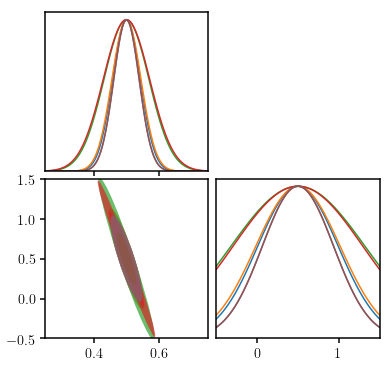

In [27]:
fig = Forecast.plotFisher(Finvs, theta_true, ranges=prior_range)